In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data_set_ALL_AML_train.csv'
data = pd.read_csv(file, index_col=1)
key = pd.read_csv('actual.csv', index_col=0)

pd.set_option('display.max_columns', 50)

sns.set()                       # sets default plot style
plt.rc('font', size=14)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # fontsize of the legend labels

drop_list = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = data.drop(columns=drop_list)

#Drop the 'Gene Description' row as it is not useful here
cleaned_data = data.drop(['Gene Description'], axis=1)
cleaned_data.columns = cleaned_data.columns.map(int)
cleaned_data.sort_index(axis=1, inplace=True)

#Transpose rows and columns so that each column is a different gene
transposed_data = cleaned_data.transpose()

#Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, transposed_data], axis=1, join='inner')

#Group by cancer type to aggregate and calculate mean and std for both cancer types
df_agg_trans = exp_data.groupby('cancer').agg(['mean', 'std'])

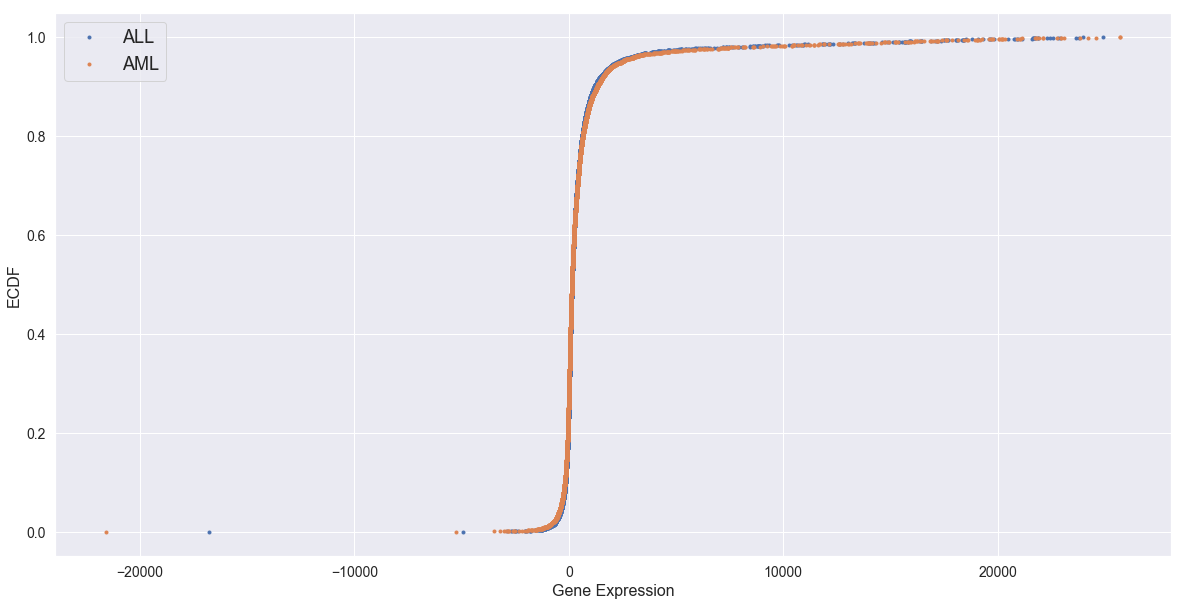

In [3]:
#Transpose dataframe so that genes form the rows
df_agg = df_agg_trans.transpose()

#Plot the empirical cumulative distribution function (ECDF) for ALL and AML mean gene expression
#First, slice out and sort ALL mean data and AML mean data to use as x-values of EDCF plots
ALL_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'ALL'])
ALL_mean = ALL_mean[ALL_mean != 0]
AML_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'AML'])
AML_mean = AML_mean[AML_mean != 0]
#Calculate y-values for ECDF plots (evenly-spaced y-values with a maximum of 1)
y = (np.arange(1, len(ALL_mean)+1)) / len(ALL_mean)

plt.figure(figsize=(20, 10))
#Generate the ALL and AML ECDF plots
plt.plot(ALL_mean, y, marker='.', linestyle='none', label='ALL')
plt.plot(AML_mean, y, marker='.', linestyle='none', label='AML')
#Adjust x-scale, label axes, add a legend, and display the plots
#plt.xscale('log')
plt.xlabel('Gene Expression')
plt.ylabel('ECDF')
plt.legend()
plt.show()

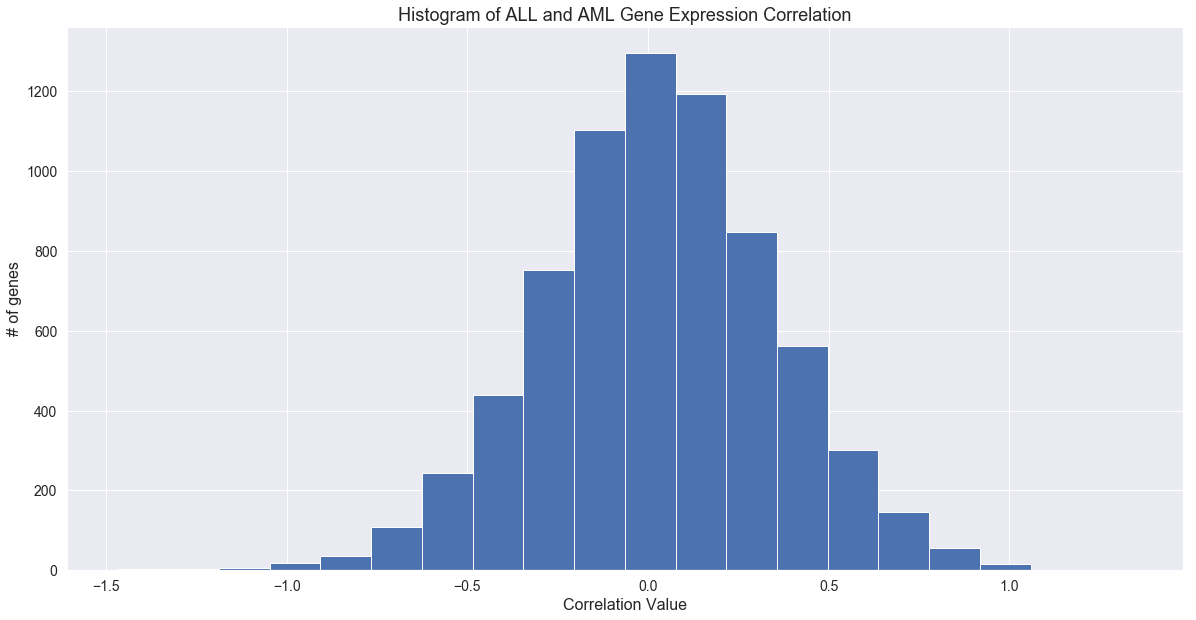

In [4]:
#Calculate the difference of ALL mean to AML mean for all genes and save in a new column, ALL:AML
df_agg.loc[(slice(None), 'mean'), 'ALL:AML'] = (df_agg['ALL'] - df_agg['AML'])
#Calculate the sum of ALL std to AML std for all genes and save column ALL:AML
df_agg.loc[(slice(None), 'std'), 'ALL:AML'] = (df_agg['ALL'] + df_agg['AML'])

mean_diff = df_agg.loc[(slice(None), 'mean'), 'ALL:AML'].copy()
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = df_agg.loc[(slice(None), 'std'), 'ALL:AML'].copy()
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

#Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)

#Plot a histogram and line plot of the correlation for each gene
df_corr['correlation'].plot(kind='hist', bins=20, figsize=(20,10))
plt.title('Histogram of ALL and AML Gene Expression Correlation')
plt.xlabel('Correlation Value')
plt.ylabel('# of genes')
plt.show()

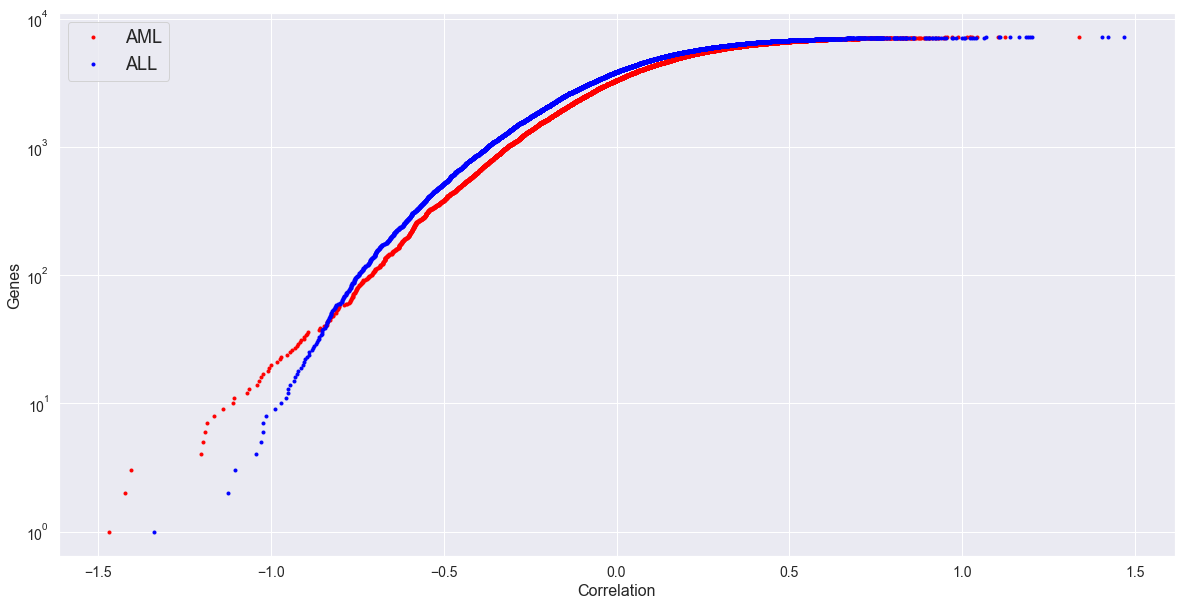

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)
    # x-data for the ECDF
    x = np.sort(data)
    # y-data for the ECDF
    y = np.arange(1, n+1)

    return x, y

AML_corr = df_corr['correlation']
ALL_corr = [-x for x in AML_corr]

# Create and plot ECDFs from original data
AML_x, AML_y = ecdf(AML_corr)
ALL_x, ALL_y = ecdf(ALL_corr)

plt.figure(figsize=(20, 10))

plt.plot(AML_x, AML_y, marker='.', linestyle='none', label='AML', color='red')
plt.plot(ALL_x, ALL_y, marker='.', linestyle='none', label='ALL', color='blue')
plt.yscale('log')
plt.xlabel('Correlation')
plt.ylabel('Genes')
plt.legend()
plt.show()

In [6]:
import random
random.seed(2158)

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates

def corr_value(data1, data2):
    """Calculate correlation value"""
    
    corr_value = (np.mean(data1) - np.mean(data2)) / (np.std(data1, ddof=1) + np.std(data2, ddof=1))
    return corr_value

df_corr_sorted = df_corr.sort_values(by=['correlation'])
df_corr_top = pd.concat([df_corr_sorted.head(25), df_corr_sorted.tail(25)])
cleaned_data_top = cleaned_data.loc[df_corr_top.index, :]

p_values = pd.DataFrame(index=cleaned_data_top.index, columns=['correlation', 'pvalue', 'ci_lower', 'ci_upper'])

for index, row in cleaned_data_top.iterrows():
    empirical_corr = corr_value(row[:27], row[27:])
    p_values.loc[index, 'correlation'] = empirical_corr
    perm_replicates = draw_perm_reps(row[:27], row[27:], corr_value, 10000)
    p_values.loc[index, 'pvalue'] = np.sum(abs(perm_replicates) >= abs(empirical_corr)) / len(perm_replicates)

In [7]:
def draw_bs_reps(data1, data2, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_sample_ALL = np.random.choice(data1, len(data1))
        bs_sample_AML = np.random.choice(data2, len(data2))
        bs_replicates[i] = func(bs_sample_ALL, bs_sample_AML)

    return bs_replicates

for index, row in cleaned_data_top.iterrows():
    bs_replicates = draw_bs_reps(row[:27], row[27:], corr_value, 10000)
    conf_int = np.percentile(bs_replicates, (2.5, 97.5))
    p_values.loc[index, 'ci_lower': 'ci_upper'] = conf_int

p_values

,correlation,pvalue,ci_lower,ci_upper
M55150_at,-1.46764,0,-2.28736,-1.13495
U50136_rna1_at,-1.42171,0,-2.24028,-1.06112
X95735_at,-1.40577,0,-2.24913,-1.08281
M16038_at,-1.20292,0,-1.96235,-0.858219
M23197_at,-1.19597,0,-1.87976,-0.864213
M84526_at,-1.19104,0,-2.22288,-0.73028
Y12670_at,-1.18474,0,-1.86553,-0.915781
U82759_at,-1.16416,0,-1.96797,-0.743736
D49950_at,-1.13979,0,-2.19873,-0.694088
M27891_at,-1.10919,0,-1.84477,-0.769979
